# totalVI DE on thymus 111 data (positive selection) with binned pseudotime

Zoë Steier

* Filtered for cells undergoing positive selection (DP to SP)
* Run totalVI DE over pseudotime and between lineages using Slingshot pseudotime
* Clustering of DE genes for further analysis

## Imports and settings

In [2]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import anndata
import copy
import seaborn as sns

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData, Dataset10X
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.preprocessing import StandardScaler
from plotnine import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

scvi.set_seed(0)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [3]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [4]:
# Plotting settings

sns.set(context="notebook", font_scale=1.3, style="ticks")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

In [5]:
# Set save path

save_path = '/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable_posselecting/'

## Load data
Cells undergoing positive selection were subset as clusters from full dataset after running totalVI. New varibale genes were selected for this subset using seurat v3 HVG method implemented in scVI, and additional genes of interested were included.

In [6]:
# Load data as anndata objects
dataset_pos_subset = anndata.read(save_path + "thymus111_pos_subset.h5ad")

In [7]:
dataset_pos_subset

AnnData object with n_obs × n_vars = 35943 × 15808
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'encode', 'ofinterest', 'hvg_encode', 'hvg_plus'
    uns: 'protein_names'
    obsm: 'protein_expression'

## Prepare dataset for totalVI

### Filter proteins and genes

In [8]:
# Filter unwanted proteins (HTO)
keep_pro_111 = np.array([not p.startswith("HTO") for p in dataset_pos_subset.uns["protein_names"]])

In [9]:
# Filter out hashtags and isotype controls
dataset_pos_subset.obsm["protein_expression"] = dataset_pos_subset.obsm["protein_expression"][:, keep_pro_111]
dataset_pos_subset.uns["protein_names"] = dataset_pos_subset.uns["protein_names"][keep_pro_111]

In [10]:
# Find highly variable genes (plus genes encoding proteins and other genes of interest) and use for totalVI
hvg_pos_subset = dataset_pos_subset.var["hvg_plus"]
hvg_pos_subset.sum()

5108

### Make totalVI dataset object

In [11]:
# All data

dataset = AnnDatasetFromAnnData(ad = dataset_pos_subset[:, hvg_pos_subset],
                                                cell_measurements_col_mappings = {"protein_expression":"protein_names"})
dataset

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


[2021-03-30 18:46:06,539] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-30 18:46:06,548] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-30 18:46:26,675] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-30 18:46:26,956] INFO - scvi.dataset.dataset | Downsampled from 35943 to 35943 cells


GeneExpressionDataset object with n_cells x nb_genes = 35943 x 5108
    gene_attribute_names: 'n_cells', 'gene_ids', 'encode', 'hvg_plus', 'gene_names', 'ofinterest', 'highly_variable', 'feature_types', 'hvg_encode'
    cell_attribute_names: 'labels', 'n_protein_counts', 'percent_mito', 'batch_indices', 'batch', 'n_counts', 'n_proteins', 'local_vars', 'protein_expression', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [12]:
# How many batches after merging? 11 from Berkeley, 8 from BioLegend (they are retained)
dataset.n_batches

19

## Load totalVI model

In [13]:
# Prepare totalVI model

totalvae = TOTALVI(dataset.nb_genes, 
                   len(dataset.protein_names),
                   n_latent = 20, 
                   n_batch=dataset.n_batches,
                  )

use_cuda = True
lr = 4e-3
n_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [14]:
# Load saved model

totalvae.load_state_dict(torch.load(save_path + "vae_37kWU.pt"))
totalvae.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=5238, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [15]:
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.95,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
    n_iter_kl_warmup=37000,   
    n_epochs_kl_warmup=None,
)

In [15]:
# Move to DE directory for next analysis
os.chdir('/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/DE_thymus/')

## Load previously saved results

### Load totalVI posterior anndata object with annotations

In [19]:
annotation_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/adata_positiveselection_filt.h5ad"

In [20]:
# load adata
post_adata = anndata.read(annotation_path)

In [21]:
post_adata

AnnData object with n_obs × n_vars = 29408 × 5108
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins', 'batch', 'n_genes', 'leiden_totalVI_res1.4', 'leiden_totalVI_res1.0', 'leiden_totalVI_res0.6', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD14_A0424_fore_prob', 'ADT_CD14_A0424', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', 'ADT_CD15(SSEA-1)_A

### Load pseudotime results

In [24]:
# Small time bins
pseudotime_data = pd.read_csv("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Slingshot_thymus/pseudotime_slingshot_binned_20210202.csv")

In [25]:
pseudotime_data

,Barcode,mean_pseudotime,Pseudotime_bin,Lineage_by_genotypeSlingshot,curve1,curve2,difference,UMAP1,UMAP2,weight_curve1,...,leiden_totalVI_res0.6,Sample,Genotype,Experiment,Location,Mouse,slingshot_clusters,Lineage_by_genotype,LinWeight_CD4,LinWeight_CD8
0,AAACCCAAGACTACCT-1-0,NaN,NaN,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCCAAGGACATCG-1-0,8.730669,8.0,unassigned,8.730669,NaN,NaN,6.462447,5.606827,1.0,...,5.0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,5.0,NaN,NaN,NaN
2,AAACCCACATTCTCCG-1-0,15.032939,14.0,unassigned,15.032939,NaN,NaN,11.693608,2.355246,1.0,...,0.0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,0.0,NaN,NaN,NaN
3,AAACGCTGTCAACACT-1-0,5.080041,5.0,unassigned,5.076519,5.083563,0.007044,2.775391,5.394828,1.0,...,2.0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,2.0,NaN,NaN,NaN
4,AAACGCTTCCATGCAA-1-0,4.517460,4.0,unassigned,4.515456,4.519465,0.004008,2.232010,5.238612,1.0,...,2.0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35938,TTTCGATCACTTCTCG-8-1,14.743658,14.0,CD4,14.743658,NaN,NaN,12.507417,3.905924,1.0,...,0.0,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,0.0,CD4,True,False
35939,TTTGACTAGCACTCGC-8-1,3.428125,3.0,CD4,3.426831,3.429418,0.002587,1.061256,5.715934,1.0,...,1.0,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,1.0,CD4,True,False
35940,TTTGATCTCACCTACC-8-1,8.935091,8.0,CD4,8.935091,NaN,NaN,6.637168,5.373678,1.0,...,5.0,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,5.0,CD4,True,False
35941,TTTGGTTTCGACCATA-8-1,13.908873,13.0,CD4,13.908873,NaN,NaN,11.650050,4.229234,1.0,...,0.0,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,0.0,CD4,True,False


## DE tests

* DE within pseudotime bins between CD4 and CD8 lineages
* DE along pseudotime within lineage

### DE within pseudotime between lineage

In [26]:
pseudotime_data["Pseudotime_bin"]

0         NaN
1         8.0
2        14.0
3         5.0
4         4.0
         ... 
35938    14.0
35939     3.0
35940     8.0
35941    13.0
35942     1.0
Name: Pseudotime_bin, Length: 35943, dtype: float64

In [27]:
# Cells to run DE on: those with a lineage assignment
assigned_cells = [lineage != "unassigned" for lineage in pseudotime_data["Lineage_by_genotypeSlingshot"]]

In [28]:
np.sum(assigned_cells)

18671

In [84]:
# Convert time bins to ints so they can be used as cell labels in totalVI DE
time_bin_int = np.nan_to_num(np.array(pseudotime_data["Pseudotime_bin"]), nan = -1).astype(int)

In [85]:
time_bin_int

array([-1,  8, 14, ...,  8, 13,  1])

In [86]:
pseudotime_data["Lineage_by_genotypeSlingshot"] == "CD4"

0        False
1        False
2        False
3        False
4        False
         ...  
35938     True
35939     True
35940     True
35941     True
35942     True
Name: Lineage_by_genotypeSlingshot, Length: 35943, dtype: bool

In [87]:
# Within cluster DE (cluster = pseudotime bin) between CD4 and CD8 lineages
# Use subset to select lineage-assigned cells
# Use cell_labels to designate pseudotime bin
# Use state to designate CD4, CD8

de_cd4_cd8, de_timebins_cd4_cd8 = full_posterior.within_cluster_degenes(
    subset = assigned_cells,
    cell_labels= time_bin_int, # must be int
    states = np.array(pseudotime_data["Lineage_by_genotypeSlingshot"] == "CD4"),
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change"
)

In [88]:
all_de = pd.concat(de_cd4_cd8) 

In [74]:
# View RNA results for CD4 lineage for a given time bin
cluster = 3 # time bin
RNA_de_filt = all_de.loc[all_de['non_zeros_proportion1'] > 0.1] # select non_zeros_proportion1 > 0.1 for RNA
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_mean'] > 0] # select mean > 0 (positive fold change)
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] # select bayes_factor > 2, which is DE
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = False) # sort by median LFC
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]] # exclude proteins

RNA_de_filt.iloc[(RNA_de_filt[["clusters"]] == cluster).values.ravel(), :][:30]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Nr4a1,0.959976,0.040024,3.177428,0.000147,0.000042,2.136097,2.242149,2.754925,-8.068367,12.219306,0.219626,0.063613,0.105140,0.034775,0.708990,0.193661,3
Egr2,0.954973,0.045027,3.054420,0.000131,0.000044,1.934993,2.041825,2.819878,-9.195383,12.080060,0.253505,0.079729,0.142523,0.033927,0.782485,0.251169,3
Hivep3,0.952772,0.047228,3.004381,0.000518,0.000161,1.817344,1.909201,1.933233,-6.484960,7.827622,0.795561,0.150127,0.372664,0.100933,2.478924,0.455776,3
Id3,0.945567,0.054433,2.854821,0.000965,0.000353,1.856481,1.861966,2.150222,-6.083807,9.055751,1.637850,0.567430,0.441589,0.194232,4.820923,1.660969,3
Cd5,0.945968,0.054032,2.862624,0.000861,0.000343,1.654812,1.683168,1.798404,-4.830872,8.306080,1.744159,0.301103,0.665888,0.198473,5.196888,0.841322,3
Ndrg1,0.936962,0.063038,2.698908,0.000103,0.000039,1.547161,1.569769,1.649596,-5.691591,6.981292,0.242991,0.037320,0.175234,0.029686,0.692787,0.101210,3
Egr1,0.940764,0.059236,2.765171,0.000507,0.000224,1.333498,1.372734,2.243030,-8.070053,10.052028,0.836449,0.268872,0.296729,0.108567,2.571524,0.901453,3
Cd6,0.927557,0.072443,2.549747,0.000533,0.000256,1.199767,1.226193,1.269035,-3.546427,6.259956,0.907710,0.275657,0.529206,0.203562,2.728481,0.889432,3
Nab2,0.924355,0.075645,2.503039,0.000513,0.000250,1.156118,1.200664,1.215644,-3.841710,5.204603,0.828271,0.381679,0.480140,0.231552,2.420153,1.121649,3
Cd69,0.925155,0.074845,2.514543,0.000595,0.000259,1.145934,1.195557,1.764980,-5.619683,8.689130,1.122664,0.355386,0.436916,0.190840,3.451105,1.118226,3


In [75]:
# View RNA results for CD8 lineage for a given time bin
cluster = 3 # time bin
RNA_de_filt = all_de.loc[all_de['non_zeros_proportion2'] > 0.1] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_mean'] < 0] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = True) 
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]] 

RNA_de_filt.iloc[(RNA_de_filt[["clusters"]] == cluster).values.ravel(), :][:30]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Cd8a,0.978587,0.021413,3.822118,0.000238,0.001637,-3.186490,-3.113459,2.018235,-11.188955,5.715678,0.101010,4.352083,0.086580,0.801042,0.280269,12.718978,4
Cd8b1,0.976786,0.023214,3.739515,0.000361,0.002152,-2.691181,-2.685430,1.584447,-8.600937,3.999972,0.279942,4.810417,0.227994,0.870833,0.821368,14.532809,4
Nkg7,0.957775,0.042225,3.121592,0.000031,0.000118,-2.494464,-2.374512,2.472245,-12.876506,8.077709,0.008658,0.343750,0.005772,0.180208,0.017350,0.943746,4
Tdrd5,0.968381,0.031619,3.421868,0.000016,0.000070,-2.362028,-2.327396,1.501422,-8.407842,6.371119,0.012987,0.179167,0.012987,0.142708,0.029897,0.541704,4
Slc16a5,0.966380,0.033620,3.358430,0.000027,0.000118,-2.239882,-2.209026,1.449190,-8.142440,3.568988,0.017316,0.198958,0.017316,0.167708,0.056331,0.640850,4
Chrna9,0.955773,0.044227,3.073196,0.000026,0.000113,-2.169439,-2.140320,1.632793,-7.625505,4.810356,0.017316,0.262500,0.015873,0.196875,0.051678,0.819714,4
Arpp21,0.953172,0.046828,3.013312,0.000054,0.000191,-1.906161,-1.819248,1.558184,-8.465690,3.565600,0.030303,0.281250,0.028860,0.189583,0.102616,0.845536,4
Klf3,0.945567,0.054433,2.854821,0.000059,0.000178,-1.664508,-1.698364,1.281563,-6.456243,3.710155,0.085137,0.329167,0.079365,0.253125,0.232522,1.010301,4
Kcna2,0.944967,0.055033,2.843216,0.000019,0.000056,-1.799072,-1.690247,1.421804,-7.494020,4.844497,0.020202,0.114583,0.015873,0.101042,0.057208,0.323509,4
Tdrp,0.952972,0.047028,3.008837,0.000102,0.000299,-1.656620,-1.627631,1.192317,-5.574309,5.910985,0.129870,0.698958,0.113997,0.416667,0.348635,2.183754,4


In [68]:
# View protein results for CD4 lineage for a given time bin

cluster = 0
protein_de_filt = all_de[["ADT" in x for x in np.array(all_de.index)]] # select proteins
protein_de_filt = protein_de_filt.loc[protein_de_filt['lfc_mean'] > 0] 
protein_de_filt = protein_de_filt.loc[protein_de_filt['bayes_factor'] > 0.7]
protein_de_filt = protein_de_filt.sort_values(by = "lfc_median", ascending = False)
protein_de_filt.iloc[(protein_de_filt[["clusters"]] == cluster).values.ravel(), :].iloc[0:10,:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_CD8b(Ly-3)_A0230,0.705823,0.294177,0.875185,496.348602,461.569580,0.131831,0.106053,0.654005,-2.318354,10.392765,358.650757,611.209412,1.000000,1.000000,NaN,NaN,0
ADT_CD8a_A0002,0.679408,0.320592,0.751051,265.302124,249.711823,0.107763,0.086624,0.582808,-1.974544,10.234452,195.612015,347.984985,1.000000,1.000000,NaN,NaN,0
ADT_CD49d_A0078,0.684010,0.315990,0.772264,4.874565,4.785297,0.017963,0.000000,0.851696,-4.327981,4.655737,4.493867,3.759624,0.916075,0.903286,NaN,NaN,0
ADT_CD62L_A0112,0.704623,0.295377,0.869409,43.709114,44.133392,0.027657,-0.018805,2.425232,-8.163826,8.181335,29.626211,51.390610,0.994835,1.000000,NaN,NaN,0


In [97]:
# View protein results for CD8 lineage for a given time bin

cluster = 7
protein_de_filt = all_de[["ADT" in x for x in np.array(all_de.index)]] # select proteins
protein_de_filt = protein_de_filt.loc[protein_de_filt['lfc_mean'] < 0] 
protein_de_filt = protein_de_filt.loc[protein_de_filt['bayes_factor'] > 0.7] 
protein_de_filt = protein_de_filt.sort_values(by = "lfc_median", ascending = True)
protein_de_filt.iloc[(protein_de_filt[["clusters"]] == cluster).values.ravel(), :].iloc[0:10,:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_CD8b(Ly-3)_A0230,0.899340,0.100660,2.189908,78.279045,435.847504,-6.566065,-9.251570,4.184849,-11.694768,8.702917,4.735308,505.934204,0.901897,1.000000,NaN,NaN,7
ADT_CD8a_A0002,0.883730,0.116270,2.028239,44.077057,270.174835,-6.095574,-8.624232,3.986779,-10.843635,8.035528,4.316520,331.858185,0.909764,1.000000,NaN,NaN,7
ADT_CD54_A0074,0.871323,0.128677,1.912705,3.513108,13.199181,-2.734528,-3.525057,2.332407,-6.900522,5.110769,2.316983,15.033626,0.712633,0.991228,NaN,NaN,7
ADT_integrinb7_A0214,0.983590,0.016410,4.093327,27.485357,163.273010,-2.545115,-2.617816,1.649343,-10.010351,7.594851,20.546507,183.907898,0.997686,1.000000,NaN,NaN,7
ADT_CD103_A0201,0.929358,0.070642,2.576863,11.178404,58.329685,-3.404845,-2.317459,2.754425,-8.936522,5.971393,11.585840,68.156433,0.990745,1.000000,NaN,NaN,7
ADT_CD71_A0441,0.911147,0.088853,2.327717,7.315500,13.757056,-1.166120,-0.881433,1.443186,-7.136845,5.641577,6.863952,15.049707,0.972235,0.998538,NaN,NaN,7
ADT_I-A-I-E_A0117,0.759256,0.240744,1.148602,11.306127,24.926994,-1.604073,-0.671222,3.232834,-8.368126,7.738331,11.260990,19.590643,0.843128,0.921053,NaN,NaN,7
ADT_CD122(IL-2Rb)_A0227,0.857114,0.142886,1.791526,1.841535,3.007845,-0.856714,-0.566211,1.005965,-4.214194,3.222680,1.421564,2.399123,0.671911,0.893275,NaN,NaN,7
ADT_CD48_A0429,0.811887,0.188113,1.462319,41.789684,58.380642,-0.508281,-0.479532,0.800107,-7.769087,7.151313,32.086071,63.919590,0.999537,1.000000,NaN,NaN,7
ADT_H-2KbboundtoSIINFEKL_A0231,0.818491,0.181509,1.506158,2.099257,2.997819,-0.548999,-0.459135,1.087758,-3.747535,3.283575,1.163350,2.570175,0.627487,0.891813,NaN,NaN,7


In [94]:
# Find the set of DE genes within pseudotime for the CD4 lineage

RNA_de_filt = all_de.loc[all_de['non_zeros_proportion1'] > 0.05] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_median'] > 0.2] 

RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = False) 
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]] 

cd4_betweenlineage = np.unique(RNA_de_filt.index.values)

In [95]:
len(cd4_betweenlineage)

302

In [100]:
# Find the set of DE genes within pseudotime for the CD8 lineage

RNA_de_filt = all_de.loc[all_de['non_zeros_proportion2'] > 0.05] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_median'] < -0.2] 

RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = True) 
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]]

cd8_betweenlineage = np.unique(RNA_de_filt.index.values)

In [101]:
len(cd8_betweenlineage)

397

In [103]:
# Collect DE between lineage genes
betweenlineage_de = np.unique(np.concatenate((cd4_betweenlineage, cd8_betweenlineage)))
len(betweenlineage_de)

607

In [89]:
# Save results
all_de.to_csv("DE_results/DE_withinPseudotime_CD4_vs_CD8_smallbin.csv")

In [5]:
# Read DE results
all_de = pd.read_csv("DE_results/DE_withinPseudotime_CD4_vs_CD8_smallbin.csv", index_col = 0)

In [25]:
all_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Ifit1,0.947368,0.052632,2.890372,1.145257e-05,1.717796e-05,-0.614018,-0.662009,2.730091,-10.584593,9.326646,0.005387,0.003980,0.004714,0.003980,0.031640,0.016077,0
Arhgap20,0.943566,0.056434,2.816597,6.532773e-06,1.138517e-05,-0.646530,-0.680414,2.525601,-10.117384,8.610246,0.004040,0.007960,0.003367,0.005970,0.022515,0.030008,0
Egr2,0.942966,0.057034,2.805378,6.969707e-05,9.226081e-05,-0.290913,-0.294554,2.756925,-10.503027,8.925255,0.060606,0.137313,0.039731,0.084577,0.240487,0.503100,0
Il21,0.942766,0.057234,2.801664,1.180512e-07,1.907373e-07,-0.678809,-0.750341,2.587326,-10.442837,9.673853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Rsad2,0.942566,0.057434,2.797961,3.226211e-06,4.290820e-06,-0.508529,-0.559257,2.468041,-9.115633,8.361154,0.002020,0.000000,0.002020,0.000000,0.008252,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADT_CD23_A0108,0.068441,0.931559,-2.610886,5.430031e-01,6.194270e-01,-0.073358,0.000000,0.606618,-5.240115,5.190649,0.578715,0.716895,0.405221,0.492237,NaN,NaN,7
ADT_CD25_A0097,0.024615,0.975385,-3.679485,6.786873e-01,6.822382e-01,0.027730,0.000000,0.738485,-7.498910,5.962466,0.857831,0.683105,0.460643,0.429224,NaN,NaN,7
ADT_CD304(Neuropilin-1)_A0552,0.016810,0.983190,-4.068823,5.384942e-01,6.368105e-01,-0.018141,0.000000,0.536018,-7.155406,4.561873,1.234538,1.303196,0.644980,0.709589,NaN,NaN,7
ADT_TER-119-ErythroidCells_A0122,0.009005,0.990995,-4.700883,5.603176e-01,5.414841e-01,0.013083,0.000000,0.426837,-5.855552,5.022054,0.713655,0.531507,0.432932,0.334247,NaN,NaN,7


### DE within lineage between pseudotime bins

In [104]:
# Run two different tests of one-vs-all treating the pseudotime bins as clusters: one for CD4 lineage, one for CD8.

# Assign cells to lineage.
CD4_cells = [lineage == "CD4" for lineage in pseudotime_data["Lineage_by_genotypeSlingshot"]]
CD8_cells = [lineage == "CD8" for lineage in pseudotime_data["Lineage_by_genotypeSlingshot"]]

In [122]:
pseudotime_data

,Barcode,Sample,Genotype,Experiment,Location,Mouse,mean_pseudotime,Lineage_by_genotype,Lineage_by_genotypeSlingshot,Pseudotime_bin
0,AAACCCAAGACTACCT-1-0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,NaN,unassigned,unassigned,NaN
1,AAACCCAAGGACATCG-1-0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,8.730669,unassigned,unassigned,Time8
2,AAACCCACATTCTCCG-1-0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,15.032939,unassigned,unassigned,Time14
3,AAACGCTGTCAACACT-1-0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,5.080041,unassigned,unassigned,Time4
4,AAACGCTTCCATGCAA-1-0,ZRS06_1_B6_r1,B6,ZRS06,Berkeley,B6_r1,4.517460,unassigned,unassigned,Time4
...,...,...,...,...,...,...,...,...,...,...
35938,TTTCGATCACTTCTCG-8-1,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,14.743658,CD4,CD4,Time14
35939,TTTGACTAGCACTCGC-8-1,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,3.428125,CD4,CD4,Time2
35940,TTTGATCTCACCTACC-8-1,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,8.935091,CD4,CD4,Time8
35941,TTTGGTTTCGACCATA-8-1,ZRS08_11_OT2_thy_r2_111,OT2,ZRS08,BioLegend,OT2_r2,13.908873,CD4,CD4,Time12


In [105]:
# Run one-vs-all test for CD4

de_cd4, de_timebins_cd4 = full_posterior.one_vs_all_degenes(
    subset = CD4_cells,
    cell_labels= time_bin_int, 
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change"
)

In [106]:
# Run one vs all test for CD8

de_cd8, de_timebins_cd8 = full_posterior.one_vs_all_degenes(
    subset = CD8_cells,
    cell_labels= time_bin_int, 
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change"
)

In [107]:
# Concatenate results
all_de_CD4 = pd.concat(de_cd4) 
all_de_CD8 = pd.concat(de_cd8) 

In [109]:
# What is DE across CD4 lineage?

RNA_de_filt = all_de_CD4.loc[all_de_CD4['non_zeros_proportion1'] > 0.05] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_median'] > 0.2] 

RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = False) 
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]]

RNA_de_filt

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Tctex1d1,0.984991,0.015009,4.183981,0.000132,0.000014,5.586523,6.172312,2.882836,-2.937547,13.923506,0.173913,0.015528,0.160681,0.014086,0.846920,0.060828,0
S1pr1,0.961777,0.038223,3.225347,0.000899,0.000204,5.374063,5.738842,3.719291,-4.032276,15.995551,1.754217,0.323742,0.767470,0.168675,4.112189,0.940373,14
Tctex1d1,0.985191,0.014809,4.197608,0.000078,0.000014,4.987865,5.430977,2.819399,-4.203228,13.017713,0.102510,0.015601,0.089958,0.014670,0.392673,0.072308,1
Sdc4,0.974785,0.025215,3.654772,0.000072,0.000011,4.942853,5.382862,2.855093,-2.958419,13.864834,0.124764,0.023070,0.102079,0.018744,0.595106,0.103700,0
Gm36520,0.983190,0.016810,4.068823,0.000022,0.000003,5.069252,5.329117,3.118879,-4.914669,14.480494,0.066372,0.008468,0.061947,0.007588,0.222137,0.022335,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shmt1,0.933760,0.066240,2.645939,0.000017,0.000013,0.182729,0.204336,2.409675,-8.216174,8.114540,0.058252,0.027198,0.058252,0.025377,0.093445,0.068886,10
Gm15417,0.888733,0.111267,2.077866,0.000043,0.000054,0.506203,0.201469,1.997518,-4.951381,9.125430,0.090421,0.135975,0.079678,0.107973,0.276571,0.389474,13
Spsb1,0.885932,0.114068,2.049841,0.000054,0.000050,0.219700,0.201420,1.387663,-4.551763,6.010485,0.071782,0.070999,0.069307,0.064544,0.222665,0.214989,7
Ddx60,0.934561,0.065439,2.658954,0.000055,0.000058,0.261311,0.201281,2.249304,-6.669591,7.998603,0.099723,0.106598,0.085873,0.083079,0.287735,0.289626,9


In [110]:
# Collect temporal genes in CD4 lineage
cd4_temporal = np.unique(RNA_de_filt.index.values)
len(np.unique(RNA_de_filt.index.values))

927

In [111]:
# What is DE across CD8 lineage?

RNA_de_filt = all_de_CD8.loc[all_de_CD8['non_zeros_proportion1'] > 0.05] 
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_median'] > 0.2] 

RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = False) 
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]]

RNA_de_filt

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Dapl1,0.990194,0.009806,4.614917,0.000334,0.000028,6.045031,6.393335,2.897188,-4.458166,14.729656,0.779909,0.054539,0.199087,0.018304,1.056695,0.091787,14
Gpr68,0.987993,0.012007,4.410168,0.000071,0.000007,5.638464,6.068472,2.645718,-3.731084,13.193266,0.245662,0.015191,0.196347,0.013821,0.357774,0.025106,14
Klrd1,0.989194,0.010806,4.516743,0.000165,0.000013,5.464350,5.798922,2.401188,-4.244984,12.805570,0.842009,0.039970,0.400913,0.025028,1.109319,0.067752,14
Itgae,0.968981,0.031019,3.441658,0.000255,0.000051,5.247957,5.609096,3.639022,-6.618834,16.070114,0.836198,0.197001,0.465116,0.115767,1.317091,0.318163,13
Itgae,0.967581,0.032419,3.396040,0.000218,0.000054,5.037590,5.426175,3.677940,-4.612735,16.382389,1.051142,0.159258,0.582648,0.095131,1.518055,0.277578,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm11707,0.889133,0.110867,2.081920,0.000036,0.000036,0.479815,0.204844,1.564939,-3.195996,6.815486,0.092072,0.096237,0.080563,0.078260,0.171213,0.147869,10
Anxa2,0.902942,0.097058,2.230347,0.000160,0.000208,0.070685,0.204300,1.406109,-4.573933,3.966323,0.249428,0.377259,0.219680,0.263437,0.752811,1.068152,6
Plxdc2,0.897338,0.102662,2.167995,0.000039,0.000042,0.302957,0.203144,1.627605,-4.615706,6.143725,0.084646,0.067417,0.074803,0.061035,0.257207,0.202783,9
Dusp5,0.902542,0.097458,2.225788,0.000070,0.000072,0.228396,0.201988,1.629969,-5.901556,6.741122,0.090261,0.118553,0.066508,0.097415,0.245384,0.329499,5


In [112]:
# Collect temporal genes in CD8 lineage
cd8_temporal = np.unique(RNA_de_filt.index.values)
len(cd8_temporal)

873

In [113]:
# Collect all temporal genes (either lineage)
all_temporal = np.unique(np.concatenate((cd4_temporal, cd8_temporal)))
len(all_temporal)                         

1113

In [114]:
# Save results
all_de_CD4.to_csv("DE_results/DE_CD4_overTime_smallbins.csv")
all_de_CD8.to_csv("DE_results/DE_CD8_overTime_smallbins.csv")

In [6]:
# Load results
all_de_CD4 = pd.read_csv("DE_results/DE_CD4_overTime_smallbins.csv", index_col = 0)
all_de_CD8 = pd.read_csv("DE_results/DE_CD8_overTime_smallbins.csv", index_col = 0)

## Clustering genes

* Cluster genes upregulated in CD4 vs CD8 lineage according to their expression pattern in the CD4 lineage
* Cluster genes upregulated in CD8 vs CD4 lineage according to their expression pattern in the CD8 lineage

### CD4-DE gene clusters

In [132]:
# Select CD4 lineage cells with assigned pseudotime values
CD4_cells_intime = np.array(CD4_cells)[~pd.isna(pseudotime_data["mean_pseudotime"]).values]

In [133]:
# Between lineage DE genes up in CD4
which_genes = cd4_betweenlineage

# Collect denoised expression values
denoised_geneset = pd.DataFrame(post_adata.obsm["denoised_genes"],
                             index = post_adata.obs.index.values, 
                                columns = post_adata.uns["totalVI_genes"])

denoised_geneset_de = denoised_geneset.loc[CD4_cells_intime, which_genes]

# Standard scaling each gene so that clusters aren't dominated by expression level
scaled_geneset_de = StandardScaler().fit_transform(X = denoised_geneset_de)

scaled_geneset_df_de = pd.DataFrame(scaled_geneset_de, 
                                index = post_adata.obs.index.values[CD4_cells_intime], 
                                columns = which_genes).transpose()

# Make adata object of denoised genes for clustering
adata_geneset_de = anndata.AnnData(X = scaled_geneset_df_de)

In [134]:
adata_geneset_de

AnnData object with n_obs × n_vars = 302 × 9545

In [135]:
sc.pp.neighbors(adata_geneset_de)

# Group genes into clusters
sc.tl.leiden(adata_geneset_de, resolution = 1.0, key_added = "leiden_1.0")

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [136]:
adata_geneset_de.obs["leiden_1.0"]

4933406C10Rik     2
9930111J21Rik2    1
A530021J07Rik     3
A630023P12Rik     3
Abcg2             2
                 ..
Zbtb7b            5
Zcchc12           4
Zfp467            5
Zfp608            2
Zfyve28           2
Name: leiden_1.0, Length: 302, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

In [137]:
# Collect data for plotting: all scaled features to plot, pseudotime, lineage and cluster id

# Add this chunk to get all cells even when genes were clustered on a subset
denoised_geneset_de = denoised_geneset.loc[:, which_genes]
scaled_geneset_de = StandardScaler().fit_transform(X = denoised_geneset_de)

scaled_df = pd.DataFrame(scaled_geneset_de, 
                            index = post_adata.obs.index.values[:], 
                            columns = which_genes)
scaled_df["pseudotime"] = pseudotime_data["mean_pseudotime"][~pd.isna(pseudotime_data["mean_pseudotime"])].values[:]
scaled_df["lineage"] = np.array(lineage_withB6)[:]

# Melt to pseudotime, Gene, Value, Cluster
scaled_melt = pd.melt(scaled_df,
                    id_vars = ["pseudotime", "lineage"],
                    value_vars = which_genes)

clusters1 = pd.DataFrame(adata_geneset_de.obs["leiden_1.0"])
scaled_melt_cluster = scaled_melt.join(clusters1, on = "variable")
grouped_scaled_de = scaled_melt_cluster.groupby(["pseudotime", "leiden_1.0", "lineage"],)["value"].mean().reset_index()
grouped_scaled_de = grouped_scaled_de.dropna(subset = ["value"])

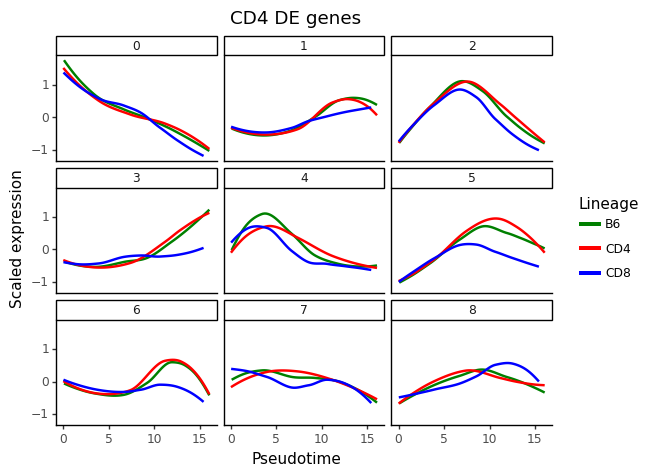

<ggplot: (8736723701453)>

In [138]:
# Preliminary view of CD4-DE genes across pseudotime for all cells grouped by lineage (see R for finalized version)
fig = (ggplot(grouped_scaled_de[grouped_scaled_de["lineage"] != "unassigned"], aes(x = "pseudotime", y = "value", group = "lineage", color = "lineage")) +
    geom_smooth(se = False, method = "loess") + 
    scale_color_manual(("green", "red", "blue")) +
    theme_classic() +
    facet_wrap("leiden_1.0") +
    labs(x = "Pseudotime", y = "Scaled expression", color = "Lineage", title = "CD4 DE genes")
    )

fig

### CD8-DE gene clusters

In [141]:
# Select CD8 lineage cells with assigned pseudotime values
CD8_cells_intime = np.array(CD8_cells)[~pd.isna(pseudotime_data["mean_pseudotime"]).values]

In [142]:
# Between lineage DE genes up in CD8
which_genes = cd8_betweenlineage
which_cells = CD8_cells_intime

# Collect denoised expression values
denoised_geneset = pd.DataFrame(post_adata.obsm["denoised_genes"],
                             index = post_adata.obs.index.values, 
                                columns = post_adata.uns["totalVI_genes"])

denoised_geneset_de = denoised_geneset.loc[which_cells, which_genes]

# Standard scaling each gene so that clusters aren't dominated by expression level
scaled_geneset_de = StandardScaler().fit_transform(X = denoised_geneset_de)

scaled_geneset_df_de = pd.DataFrame(scaled_geneset_de, 
                                index = post_adata.obs.index.values[which_cells], 
                                columns = which_genes).transpose()

# Make adata object of denoised genes for clustering
adata_geneset_de8 = anndata.AnnData(X = scaled_geneset_df_de)

In [143]:
adata_geneset_de8

AnnData object with n_obs × n_vars = 397 × 9126

In [144]:
sc.pp.neighbors(adata_geneset_de8)

# Group genes into clusters
sc.tl.leiden(adata_geneset_de8, resolution = 1.0, key_added = "leiden_1.0")

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [145]:
# Collect data for plotting: all scaled features to plot, pseudotime, lineage and cluster id

# Add this chunk to get all cells even when genes were clustered on a subset
denoised_geneset_de = denoised_geneset.loc[:, which_genes]
scaled_geneset_de = StandardScaler().fit_transform(X = denoised_geneset_de)

scaled_df = pd.DataFrame(scaled_geneset_de, 
                            index = post_adata.obs.index.values[:], 
                            columns = which_genes)
scaled_df["pseudotime"] = pseudotime_data["mean_pseudotime"][~pd.isna(pseudotime_data["mean_pseudotime"])].values[:]
scaled_df["lineage"] = np.array(lineage_withB6)[:]

# Melt to pseudotime, Gene, Value, Cluster
scaled_melt = pd.melt(scaled_df,
                    id_vars = ["pseudotime", "lineage"],
                    value_vars = which_genes)

clusters1 = pd.DataFrame(adata_geneset_de8.obs["leiden_1.0"])
scaled_melt_cluster = scaled_melt.join(clusters1, on = "variable")
grouped_scaled_de = scaled_melt_cluster.groupby(["pseudotime", "leiden_1.0", "lineage"],)["value"].mean().reset_index()
grouped_scaled_de = grouped_scaled_de.dropna(subset = ["value"])

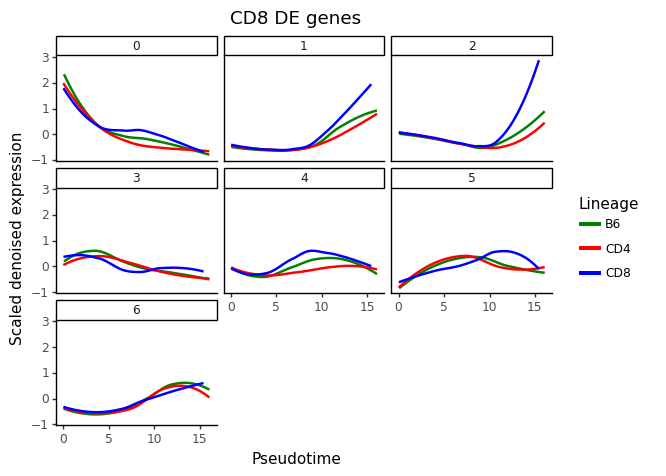

<ggplot: (8736697782357)>

In [153]:
# Preliminary view of CD8-DE genes across pseudotime for all cells grouped by lineage (see R for finalized version)
fig = (ggplot(grouped_scaled_de[grouped_scaled_de["lineage"] != "unassigned"], aes(x = "pseudotime", y = "value", group = "lineage", color = "lineage")) +
    geom_smooth(se = False, method = "loess") + 
    scale_color_manual(("green", "red", "blue")) +
    theme_classic() +
    facet_wrap("leiden_1.0") +
    labs(x = "Pseudotime", y = "Scaled denoised expression", color = "Lineage", title = "CD8 DE genes")
    )

fig

### Save gene cluster results

In [166]:
os.getcwd()

'/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/DE_thymus'

In [162]:
# Save CD8-DE gene clusters

adata_geneset_de8.obs["leiden_1.0"].to_csv(
    '/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/DE_thymus/DE_results/clusteredDE_CD8_genes_smallbins.csv',
 header = ["Cluster"], index_label = "Gene")

In [163]:
# Save CD4-DE gene clusters

adata_geneset_de.obs["leiden_1.0"].to_csv(
    '/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/DE_thymus/DE_results/clusteredDE_CD4_genes_smallbins.csv',
 header = ["Cluster"], index_label = "Gene")